Mounted at /content/drive
Found 1836 images belonging to 8 classes.
Found 459 images belonging to 8 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training the top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1019s 17s/step - accuracy: 0.4500 - loss: 1.6863 - val_accuracy: 0.5490 - val_loss: 1.4464 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 868ms/step - accuracy: 0.7173 - loss: 0.8296 - val_accuracy: 0.5926 - val_loss: 1.1860 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 908ms/step - accuracy: 0.7553 - loss: 0.6439 - val_accuracy: 0.6078 - val_loss: 1.0381 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 893ms/step - accuracy: 0.7922 - loss: 0.5790 - val_accuracy: 0.7211 - val_loss: 0.7763 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 80s 855ms/step - accuracy: 0.8347 - loss: 0.4594 - val_accuracy: 0.7930 - val_loss: 0.5960 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 885ms/step - accuracy: 0.8188 - loss: 0.4595 - val_accuracy: 0.8105 - val_loss: 0.5729 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 838ms/step - acc

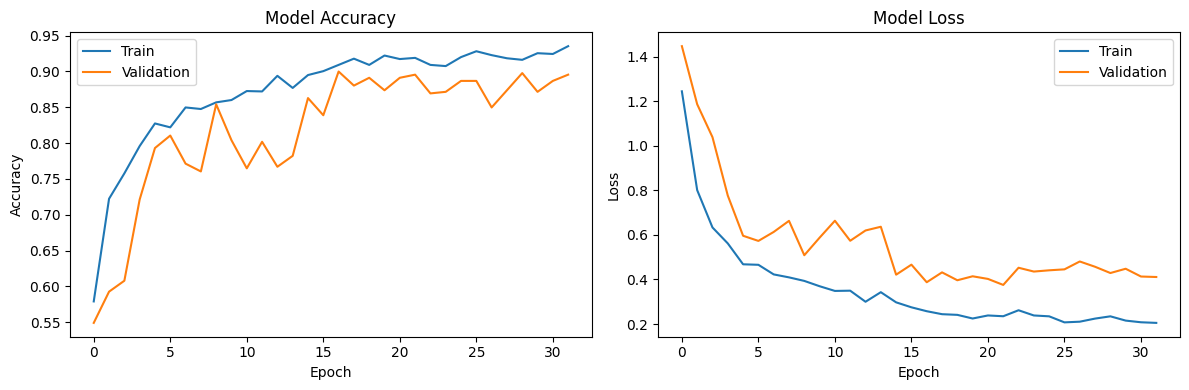

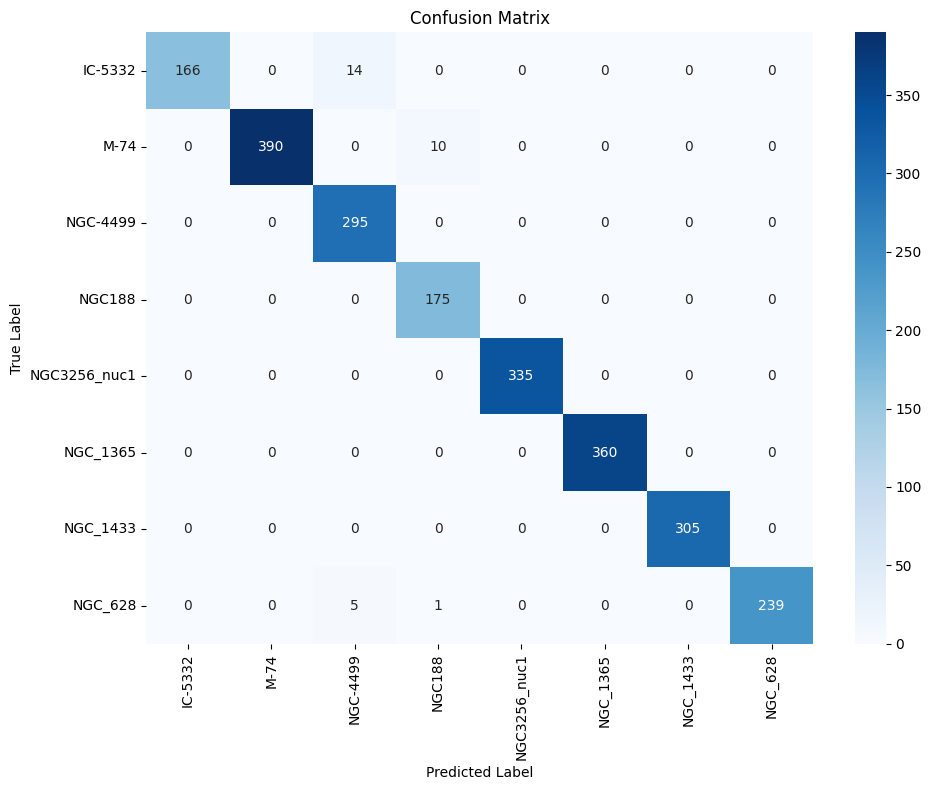

In [ ]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

# Configuration
IMG_SIZE = 224  # VGG16 recommended input size
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

def create_model(num_classes):
    """Create VGG16-based model with fine-tuning"""

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)  # VGG16 does not have GAP layer
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with augmentation."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Project-Review-3/Project-Review-3/Dataset'  # Update if needed

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    # Load and prepare the data
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_generator.class_indices)

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            '/content/drive/MyDrive/Project-Review-3/Project-Review-3/vgg16_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    print("Training the top layers...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Fine-tuning the model...")
    total_layers = len(base_model.layers)
    for layer in base_model.layers[int(total_layers * 0.7):]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE / 10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = model.fit(
        train_generator,
        epochs=EPOCHS // 2,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Evaluating the model...")
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

# Configuration
IMG_SIZE = 224  # VGG16 recommended input size
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

def create_model(num_classes):
    """Create VGG16-based model with fine-tuning"""

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)  # VGG16 does not have GAP layer
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with augmentation."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Update if needed

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    # Load and prepare the data
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_generator.class_indices)

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            '/content/drive/MyDrive/Project-Review-3/Project-Review-3/vgg16_model_2.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    print("Training the top layers...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Fine-tuning the model...")
    total_layers = len(base_model.layers)
    for layer in base_model.layers[int(total_layers * 0.7):]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE / 10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = model.fit(
        train_generator,
        epochs=EPOCHS // 2,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Evaluating the model...")
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1828 images belonging to 8 classes.
Found 457 images belonging to 8 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training the top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1547s 27s/step - accuracy: 0.4407 - loss: 1.6249 - val_accuracy: 0.3567 - val_loss: 1.7541 - learning_rate: 1.0000e-04
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1485s 26s/step - accuracy: 0.6937 - loss: 0.8396 - val_accuracy: 0.5624 - val_loss: 1.2337 - learning_rate: 1.0000e-04
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1464s 25s/step - accuracy: 0.7678 - loss: 0.6411 - val_accuracy: 0.6652 - val_loss: 0.9708 - learning_rate: 1.0000e-04
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1499s 26s/step - accuracy: 0.7660 - loss: 0.6532 - val_accuracy: 0.6893 - val_loss: 0.8401 - learning_rate: 1.0000e-04
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1511s 26s/step - accuracy: 0.7973 - loss: 0.5247 - val_accuracy: 0.8074 - val_loss: 0.6274 - learning_rate: 1.0000e-04
Epoch 6/15
39/58 ━━━━━━━━━━━━━━━━━━━━ 6:22 20s/step - accuracy: 0.8036 - loss: 0.4999